#### a) Importing libraries

In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from scipy.stats import norm
from datetime import datetime
from statsmodels.stats.stattools import jarque_bera
from statsmodels.multivariate.pca import PCA
from statsmodels.multivariate.factor import Factor
from statsmodels.multivariate.factor_rotation import rotate_factors

#### b) Importing data

In [156]:
#Importing data 
data = pd.read_csv('my_group_data copy.csv', index_col='Date', parse_dates=True, dayfirst=True)

#### c) Inspecting data

In [157]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2532 entries, 2011-09-26 to 2021-09-24
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RIO.AX  2532 non-null   float64
 1   TLS.AX  2532 non-null   float64
 2   WES.AX  2532 non-null   float64
 3   CPU.AX  2532 non-null   float64
 4   SEK.AX  2532 non-null   float64
 5   WOW.AX  2532 non-null   float64
 6   CBA.AX  2532 non-null   float64
 7   WBC.AX  2532 non-null   float64
dtypes: float64(8)
memory usage: 178.0 KB


CPU, CBA and WBC series contained missing values as stocks haven't been trading (Trading Volume=0) on some few days over the past years. Therefore, we decided to proceed via imputation to resolve the issue.
Precisely, the missing values have been imputed with the last available adjusted closing price of the respective stock.

The reason for the choice is that past day prices are a good proxy and that on the secific day no market events could have happen to chnage the price.

Also, we decided not to proceed with the dropping of entire observations as the remaining stocks could have experience particular price behaviours on those specific days. Thus, potentially leading to the distortion of the analysis.

In [158]:
data.head()

,RIO.AX,TLS.AX,WES.AX,CPU.AX,SEK.AX,WOW.AX,CBA.AX,WBC.AX
Date,,,,,,,,
2011-09-26,39.712032,1.942921,12.923607,5.573087,3.980642,17.424408,26.109711,11.411721
2011-09-27,41.836163,1.955703,13.381684,5.678382,4.223364,17.522896,27.121952,12.042071
2011-09-28,42.251755,1.974877,13.521650,5.731029,4.304272,17.642477,27.092180,12.279938
2011-09-29,41.196289,1.974877,13.428337,5.685903,4.263817,17.586203,27.098141,12.220470
2011-09-30,40.767490,1.981268,13.398647,5.618213,4.304272,17.487720,27.121952,12.095592


In [159]:
data.tail()

,RIO.AX,TLS.AX,WES.AX,CPU.AX,SEK.AX,WOW.AX,CBA.AX,WBC.AX
Date,,,,,,,,
2021-09-20,95.239998,3.88,56.900002,16.280001,29.590000,39.209999,100.809998,25.299999
2021-09-21,95.709999,3.93,57.389999,16.510000,29.709999,39.360001,100.339996,25.190001
2021-09-22,98.269997,3.95,57.230000,16.330000,29.860001,39.250000,99.639999,24.910000
2021-09-23,98.860001,3.98,57.490002,16.930000,30.490000,39.060001,100.800003,25.070000
2021-09-24,99.330002,3.95,57.360001,17.900000,30.530001,39.290001,101.699997,25.250000


#### d) Calculating log-returns (%)

In [160]:
x = np.log(data).diff() * 100
x

,RIO.AX,TLS.AX,WES.AX,CPU.AX,SEK.AX,WOW.AX,CBA.AX,WBC.AX
Date,,,,,,,,
2011-09-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-09-27,5.210688,0.655750,3.483130,1.871724,5.918904,0.563638,3.803614,5.376546
2011-09-28,0.988479,0.975614,1.040520,0.922870,1.897590,0.680110,-0.109830,1.956039
2011-09-29,-2.529770,0.000000,-0.692494,-0.790514,-0.944311,-0.319481,0.021998,-0.485440
2011-09-30,-1.046322,0.323089,-0.221343,-1.197638,0.944311,-0.561570,0.087832,-1.027140
...,...,...,...,...,...,...,...,...
2021-09-20,-3.669764,-1.025649,-0.665613,-2.247279,-3.421695,-0.458017,-2.032570,-2.266607
2021-09-21,0.492278,1.280426,0.857469,1.402887,0.404719,0.381829,-0.467315,-0.435725
2021-09-22,2.639598,0.507615,-0.279183,-1.096237,0.503615,-0.279864,-0.700070,-1.117779


In [161]:
# Taking out 1st row because it contains NaN values
log_r = x.iloc[1: , :]
log_r

,RIO.AX,TLS.AX,WES.AX,CPU.AX,SEK.AX,WOW.AX,CBA.AX,WBC.AX
Date,,,,,,,,
2011-09-27,5.210688,0.655750,3.483130,1.871724,5.918904,0.563638,3.803614,5.376546
2011-09-28,0.988479,0.975614,1.040520,0.922870,1.897590,0.680110,-0.109830,1.956039
2011-09-29,-2.529770,0.000000,-0.692494,-0.790514,-0.944311,-0.319481,0.021998,-0.485440
2011-09-30,-1.046322,0.323089,-0.221343,-1.197638,0.944311,-0.561570,0.087832,-1.027140
2011-10-04,-4.636567,-3.278966,-5.031071,-4.238481,-4.027383,-1.826718,-4.582002,-5.041383
...,...,...,...,...,...,...,...,...
2021-09-20,-3.669764,-1.025649,-0.665613,-2.247279,-3.421695,-0.458017,-2.032570,-2.266607
2021-09-21,0.492278,1.280426,0.857469,1.402887,0.404719,0.381829,-0.467315,-0.435725
2021-09-22,2.639598,0.507615,-0.279183,-1.096237,0.503615,-0.279864,-0.700070,-1.117779


## Principal Component Analysis (PCA)

In [162]:
#PCA Implementation
class MyPca:
    def __init__(self, log_r):
        self.log_r = log_r.values
        self.n = self.log_r.shape[0]
        self.d = self.log_r.shape[1]
        self.mu = np.mean(self.log_r, axis=0)
        self.eigval = None
        self.weight = None

    def fit(self):
        c = np.cov(self.log_r.T)
        eigval, weight = np.linalg.eig(c)
        idx = np.argsort(-eigval)
        self.eigval = eigval[idx]
        self.weight = weight[:, idx]
    
    def transform(self, n_comp):
        x = self.log_r - np.tile(self.mu, (self.n, 1))
        return np.dot(x, self.weight[:, :n_comp])
    
    def prop_var_explained(self):
        return self.eigval / np.sum(self.eigval)
    
    def biplot2d(self):
        ax = plt.axes()
        for i in range(self.d):
            w = self.weight[i, :]
            ax.plot([0, w[0]], [0, w[1]])
            ax.scatter(w[0], w[1])
        ax.axhline(y=0, color='k', alpha=0.6)
        ax.axvline(x=0, color='k', alpha=0.6)
        lim = np.max(np.abs(self.weight[:, :2]))
        lim = lim + 0.1 * lim
        ax.axis([-lim, lim, -lim, lim])
        ax.grid(True)
        ax.set_xlabel('Component 1')
        ax.set_ylabel('Component 2')
        return ax
    
    def biplot3d(self):
        ax = plt.axes(projection="3d")
        for i in range(self.d):
            w = self.weight[i, :]
            ax.plot([0, w[0]], [0, w[1]], [0, w[2]])
            ax.scatter(w[0], w[1], w[2])
        lim = np.max(np.abs(self.weight[:, :3]))
        lim = lim + 0.1 * lim
        ax.axis([-lim, lim, -lim, lim])
        ax.set_zbound(lower=-lim, upper=lim)
        ax.plot([-lim, lim], [0, 0], [0, 0], 'k', alpha=0.6)
        ax.plot([0, 0], [-lim, lim], [0, 0], 'k', alpha=0.6)
        ax.plot([0, 0], [0, 0], [-lim, lim], 'k', alpha=0.6)
        ax.grid(True)
        ax.set_xlabel('Component 1')
        ax.set_ylabel('Component 2')
        ax.set_zlabel('Component 3')
        return ax

In [163]:
# Weights
pca = MyPca(log_r)
pca.fit()
print(pca.weight)

[[ 3.61952086e-01  5.89550481e-01  6.87647498e-01  1.93609720e-01
   1.04274745e-01 -8.95024388e-03 -1.10972705e-02  7.95421051e-04]
 [ 2.07058066e-01  9.90869316e-02 -3.11858630e-01  2.09016877e-01
   3.37806313e-01 -8.13402636e-01  1.72164257e-01  3.14227953e-02]
 [ 2.97131112e-01  4.99696855e-02 -2.93516800e-01  1.75143499e-01
   2.19035165e-01  1.52726956e-01 -8.47708814e-01  4.97656166e-02]
 [ 3.90293774e-01 -4.74652073e-02  3.08690644e-02 -8.62971004e-01
   3.14684908e-01 -4.36124684e-03  2.50405213e-02 -8.56337666e-03]
 [ 4.82940723e-01 -7.63697257e-01  3.30329707e-01  2.64689506e-01
  -2.50987087e-02 -2.74162147e-02  5.37044235e-02  9.52621429e-03]
 [ 2.49927414e-01  1.01501469e-01 -3.43170925e-01  2.63156957e-01
   4.32017946e-01  5.59975193e-01  4.83812783e-01  7.70022089e-02]
 [ 3.61499644e-01  1.34194929e-01 -2.43735063e-01  8.80108852e-03
  -4.07038325e-01  2.00662294e-02  7.30331014e-02 -7.87660335e-01]
 [ 3.98903585e-01  1.62227517e-01 -2.37674824e-01 -6.35880839e-02
  -

In [164]:
c_name = ['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7', 'PC 8']
tbl_pca = pd.DataFrame(pca.weight.round(4), index=data.columns, columns=c_name)
tbl_pca

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8
RIO.AX,0.3620,0.5896,0.6876,0.1936,0.1043,-0.0090,-0.0111,0.0008
TLS.AX,0.2071,0.0991,-0.3119,0.2090,0.3378,-0.8134,0.1722,0.0314
WES.AX,0.2971,0.0500,-0.2935,0.1751,0.2190,0.1527,-0.8477,0.0498
CPU.AX,0.3903,-0.0475,0.0309,-0.8630,0.3147,-0.0044,0.0250,-0.0086
SEK.AX,0.4829,-0.7637,0.3303,0.2647,-0.0251,-0.0274,0.0537,0.0095
WOW.AX,0.2499,0.1015,-0.3432,0.2632,0.4320,0.5600,0.4838,0.0770
CBA.AX,0.3615,0.1342,-0.2437,0.0088,-0.4070,0.0201,0.0730,-0.7877
WBC.AX,0.3989,0.1622,-0.2377,-0.0636,-0.6124,-0.0150,0.0933,0.6083


In [165]:
tbl_mat = np.vstack([
        pca.eigval,
        pca.prop_var_explained(),
        np.cumsum(pca.prop_var_explained())])
tbl_eigval = pd.DataFrame(tbl_mat.round(4),
    index=['Eigenvalue', '% Variance', 'Cumulative'],
    columns=c_name)
tbl_eigval

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8
Eigenvalue,8.2177,2.3483,1.9592,1.6777,1.3119,1.0134,0.6165,0.2974
% Variance,0.4711,0.1346,0.1123,0.0962,0.0752,0.0581,0.0353,0.0170
Cumulative,0.4711,0.6058,0.7181,0.8143,0.8895,0.9476,0.9830,1.0000


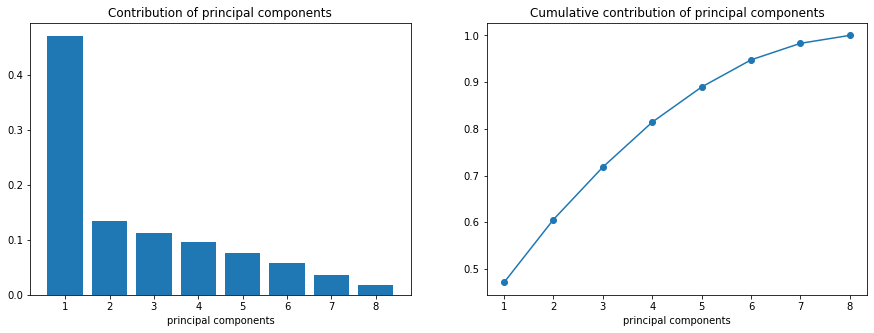

In [166]:
plt.figure(figsize=(15, 5))

number_of_components = len(pca.prop_var_explained())

plt.subplot(1, 2, 1)
plt.bar(np.arange(number_of_components) + 1, pca.prop_var_explained())
plt.title('Contribution of principal components')
plt.xlabel('principal components')

plt.subplot(1, 2, 2)
plt.plot(np.arange(number_of_components) + 1, np.cumsum(pca.prop_var_explained()), 'o-')
plt.title('Cumulative contribution of principal components')
plt.xlabel('principal components');
plt.show()

In [167]:
# Eigenvalues (explained variance)
print(pca.eigval)

[8.21772282 2.3482564  1.95921092 1.67774966 1.31186818 1.01340462
 0.61645128 0.29737693]


In [168]:
# Explained variance (%)
print(pca.prop_var_explained())

[0.47114457 0.13463197 0.11232693 0.09618999 0.075213   0.05810126
 0.03534284 0.01704943]


In [169]:
# Variation expalined by each individual component
pca.prop_var_explained()

array([0.47114457, 0.13463197, 0.11232693, 0.09618999, 0.075213  ,
       0.05810126, 0.03534284, 0.01704943])

In [170]:
# Cumulated Variation as we included more components
np.cumsum(pca.prop_var_explained())

array([0.47114457, 0.60577654, 0.71810348, 0.81429346, 0.88950646,
       0.94760772, 0.98295057, 1.        ])

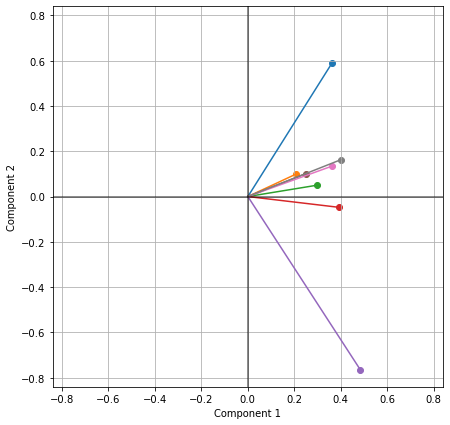

In [171]:
# Biplot
plt.figure(figsize=(7, 7))
pca.biplot2d()
plt.show()

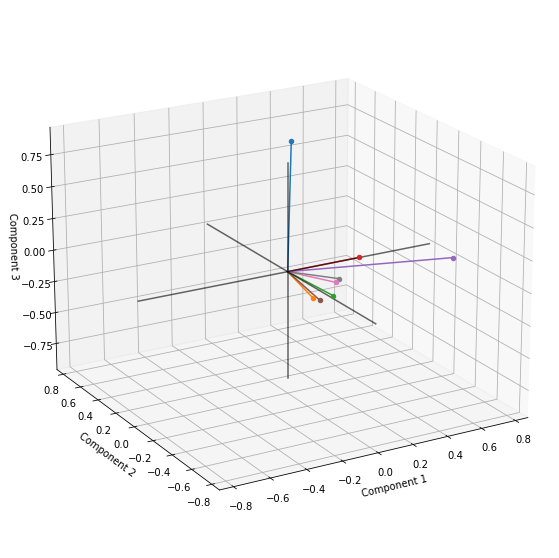

In [172]:
# 3D biplot
plt.figure(figsize=(10, 10))
ax = pca.biplot3d()
ax.view_init(20, -120)
plt.show()

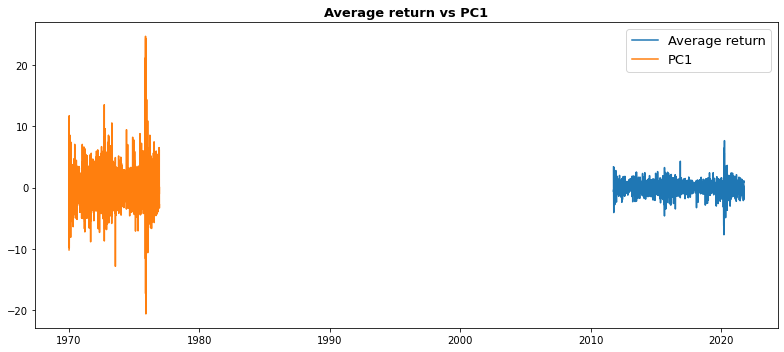

In [173]:
pc = pca.transform(n_comp=3)
pc[:,0] = (-1)*pc[:,0]

plt.figure(figsize=(11, 5))
plt.plot(log_r.mean(axis=1), label='Average return')
plt.plot(pc[:,0], label='PC1')
plt.title('Average return vs PC1', fontsize=13, weight='bold')
plt.legend(fontsize=13)
plt.tight_layout()
plt.show()

## Factor Analysis

In [174]:
# Sample correlation matrix 
log_r.corr()

,RIO.AX,TLS.AX,WES.AX,CPU.AX,SEK.AX,WOW.AX,CBA.AX,WBC.AX
RIO.AX,1.000000,0.219045,0.313160,0.325313,0.279959,0.259660,0.403502,0.400347
TLS.AX,0.219045,1.000000,0.432200,0.241640,0.238745,0.347203,0.386753,0.338723
WES.AX,0.313160,0.432200,1.000000,0.380599,0.404946,0.557080,0.563177,0.506858
CPU.AX,0.325313,0.241640,0.380599,1.000000,0.408073,0.278818,0.457882,0.462006
SEK.AX,0.279959,0.238745,0.404946,0.408073,1.000000,0.287734,0.432428,0.412324
WOW.AX,0.259660,0.347203,0.557080,0.278818,0.287734,1.000000,0.449792,0.369972
CBA.AX,0.403502,0.386753,0.563177,0.457882,0.432428,0.449792,1.000000,0.829803
WBC.AX,0.400347,0.338723,0.506858,0.462006,0.412324,0.369972,0.829803,1.000000


In [175]:
'''
Biplot for a given weight matrix
'''
def biplot(weight, labels=None):
    ax = plt.axes()
    for i in range(weight.shape[0]):
        w = weight[i, :]
        if labels is None:
            ax.plot([0, w[0]], [0, w[1]])
        else:
            ax.plot([0, w[0]], [0, w[1]], label=labels[i])
        ax.scatter(w[0], w[1])
    ax.axhline(y=0, color='k', alpha=0.6)
    ax.axvline(x=0, color='k', alpha=0.6)
    lim = np.max(np.abs(weight[:, :2]))
    lim = lim + 0.1 * lim
    ax.axis([-lim, lim, -lim, lim])
    ax.grid(True)
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    return ax

'''
3D biplot for a given weight matrix
'''
def biplot3d(weight):
    ax = plt.axes(projection="3d")
    for i in range(weight.shape[0]):
        w = weight[i, :]
        ax.plot([0, w[0]], [0, w[1]], [0, w[2]])
        ax.scatter(w[0], w[1], w[2])
    lim = np.max(np.abs(weight[:, :3]))
    lim = lim + 0.1 * lim
    ax.axis([-lim, lim, -lim, lim])
    ax.set_zbound(lower=-lim, upper=lim)
    ax.plot([-lim, lim], [0, 0], [0, 0], 'k', alpha=0.6)
    ax.plot([0, 0], [-lim, lim], [0, 0], 'k', alpha=0.6)
    ax.plot([0, 0], [0, 0], [-lim, lim], 'k', alpha=0.6)
    ax.grid(True)
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    return ax

### i) 1 factor (m=1)

In [176]:
#Fitting the Factor Analysis with m=1
fm1 = Factor(endog=log_r, n_factor=1, method='ml')
result1 = fm1.fit()

In [177]:
# Standardised factor loadings
result1.loadings

array([[0.46218488],
       [0.44021944],
       [0.63972847],
       [0.53246156],
       [0.50107263],
       [0.50681852],
       [0.91790347],
       [0.87496598]])

In [178]:
# Factor loadings (regression coefficients), i.e. rescaled to be on the scale of y (i.e. the returns data).
result1.loadings[:, 0] * log_r.std()

RIO.AX    0.786601
TLS.AX    0.535184
WES.AX    0.778773
CPU.AX    0.864942
SEK.AX    0.953479
WOW.AX    0.639696
CBA.AX    1.174866
WBC.AX    1.266303
dtype: float64

In [179]:
result1.uniqueness
ser2 = result1.uniqueness * log_r.var() 
ser = np.sqrt(ser2)
r2 = np.sqrt(result1.communality * log_r.var())     # re-scaled to be for actual data

tbl_r = pd.DataFrame({'Sample STD': data.std().round(4),
                      'Communal STD': r2.round(4),
                      'Specific STD' : ser.round(4)})
tbl_r.T

,RIO.AX,TLS.AX,WES.AX,CPU.AX,SEK.AX,WOW.AX,CBA.AX,WBC.AX
Sample STD,25.3390,0.7571,11.4309,3.5124,6.5201,6.5430,15.3201,4.0893
Communal STD,0.7866,0.5352,0.7788,0.8649,0.9535,0.6397,1.1749,1.2663
Specific STD,1.5092,1.0916,0.9357,1.3750,1.6468,1.0881,0.5079,0.7007


In [180]:
r2 = result1.communality * log_r.var()    # re-scaled to be for actual data
communal_var = result1.communality * log_r.var()

tbl_r = pd.DataFrame({'Sample Variance': log_r.var().round(4),
                      'Communal Variance': communal_var.round(4),
                      'Specific Variance' : ser.round(4)**2})
tbl_r.T

,RIO.AX,TLS.AX,WES.AX,CPU.AX,SEK.AX,WOW.AX,CBA.AX,WBC.AX
Sample Variance,2.896500,1.478000,1.481900,2.638700,3.62090,1.593100,1.638300,2.09460
Communal Variance,0.618700,0.286400,0.606500,0.748100,0.90910,0.409200,1.380300,1.60350
Specific Variance,2.277685,1.191591,0.875534,1.890625,2.71195,1.183962,0.257962,0.49098


In [181]:
#Total data variance captured by FM m=1
total_data_variance = np.sum(log_r.var())
total_communal_variance = np.sum(result1.communality * log_r.var())
total_communal_variance / total_data_variance

0.3762141383153286

### ii) 2 factors (m=2)

In [182]:
#Fitting the Factor Analysis with m=2
fm2 = Factor(endog=log_r, n_factor=2, method='ml')
result2 = fm2.fit()

In [183]:
# Standardised factor loadings
result2.loadings

array([[-0.45732608, -0.06283236],
       [-0.43781005, -0.28695287],
       [-0.65879023, -0.48086763],
       [-0.52875564, -0.08631787],
       [-0.49563663, -0.15729244],
       [-0.50956777, -0.4459024 ],
       [-0.8967087 ,  0.04511492],
       [-0.91353048,  0.20663897]])

In [184]:
# Actual loadings with Factor 1 by (-1)
tbl_loading2 = pd.DataFrame({'Factor 1': round(result2.loadings[:,0] * log_r.std() * (-1), 4),
                             'Factor 2': round(result2.loadings[:,1] * log_r.std(), 4)})
tbl_loading2

,Factor 1,Factor 2
RIO.AX,0.7783,-0.1069
TLS.AX,0.5323,-0.3489
WES.AX,0.8020,-0.5854
CPU.AX,0.8589,-0.1402
SEK.AX,0.9431,-0.2993
WOW.AX,0.6432,-0.5628
CBA.AX,1.1477,0.0577
WBC.AX,1.3221,0.2991


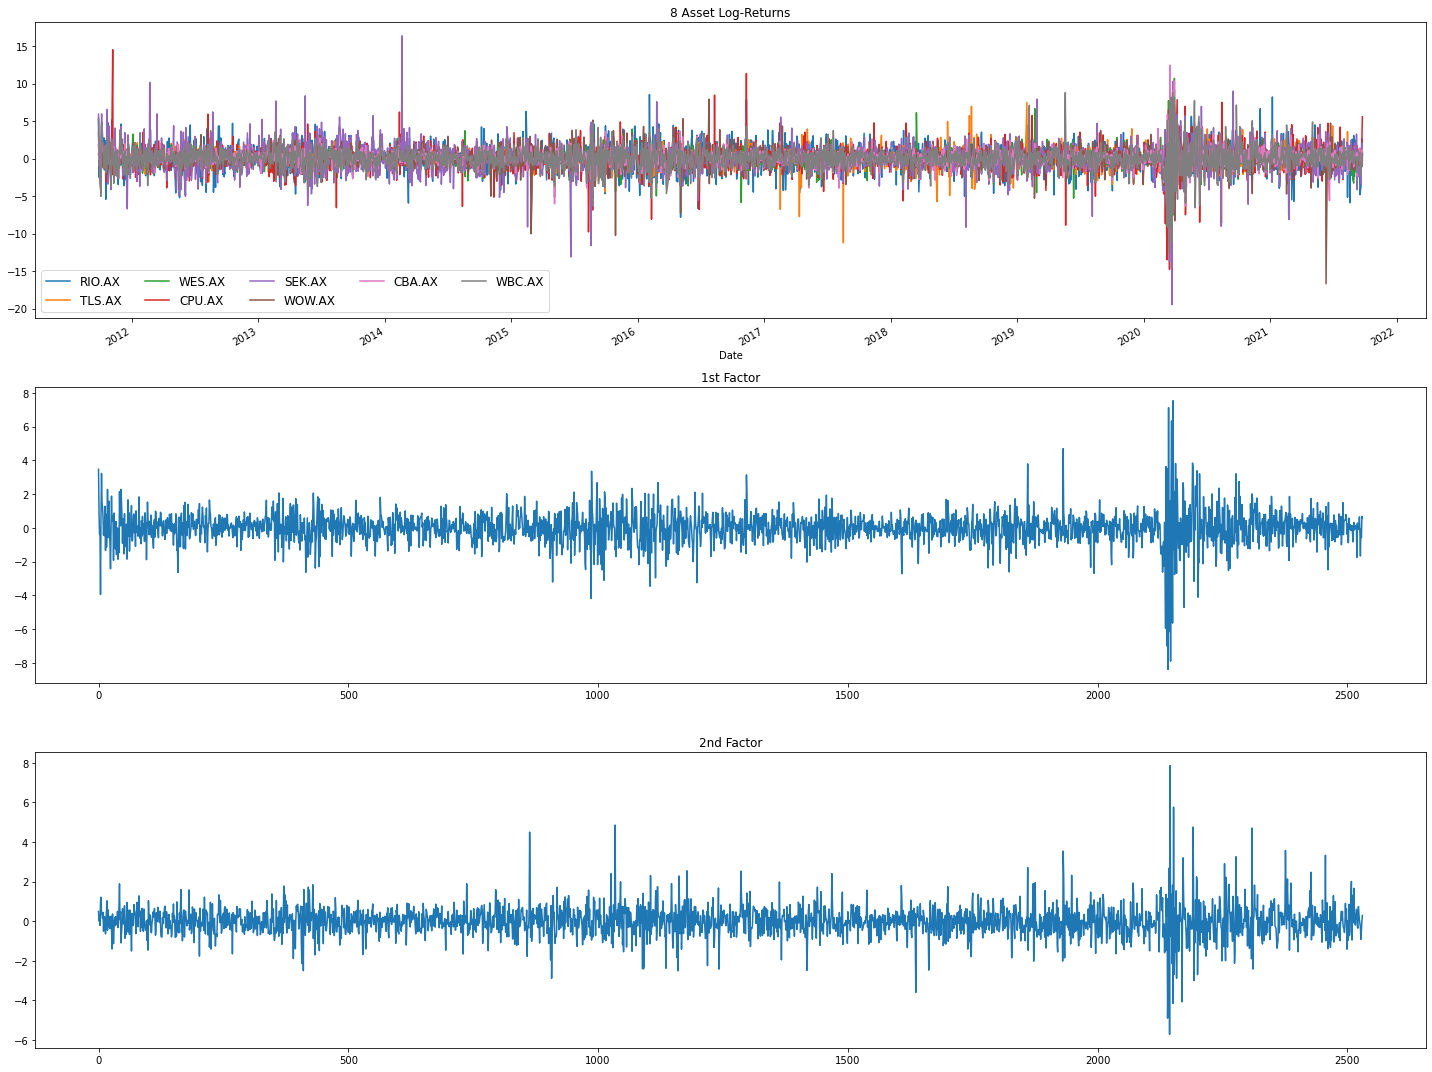

In [185]:
score_2 = result2.factor_scoring(method='regression', transform=True)
fig, ax = plt.subplots(3, 1, figsize=(20, 15))
log_r.plot(ax=ax[0])
ax[0].set_title('8 Asset Log-Returns')
ax[0].legend(loc='best', ncol=5, fontsize=12)
ax[1].plot(score_2[:,0] * (-1))
ax[1].set_title('1st Factor')
ax[2].plot(score_2[:,1])
ax[2].set_title('2nd Factor')
plt.tight_layout()
plt.show()

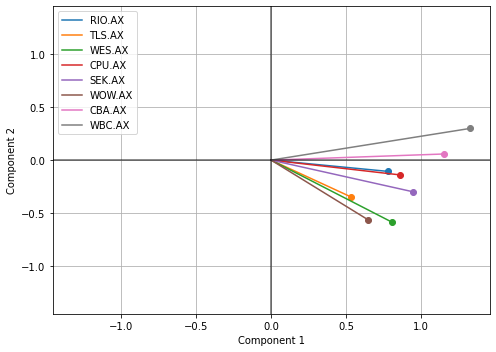

In [186]:
plt.figure(figsize=(7, 5))
biplot(tbl_loading2.values, labels=log_r.columns)
plt.tight_layout()
plt.legend()
plt.show()

In [187]:
ser2_2 = result2.uniqueness * log_r.var() 
ser_2 = np.sqrt(ser2_2)
r2_2 = result2.communality * log_r.var()

tbl_r_2 = pd.DataFrame({'Sample Var': log_r.var().round(4),
                        'Specific Var (m=1)' : ser2.round(4),
                        'Specific Var (m=2)' : ser2_2.round(4),
                        'Communal Var (m=1)': r2.round(4),
                        'Communal Var (m=2)': r2_2.round(4)})
tbl_r_2.T

,RIO.AX,TLS.AX,WES.AX,CPU.AX,SEK.AX,WOW.AX,CBA.AX,WBC.AX
Sample Var,2.8965,1.4780,1.4819,2.6387,3.6209,1.5931,1.6383,2.0946
Specific Var (m=1),2.2778,1.1916,0.8755,1.8906,2.7118,1.1839,0.2579,0.4910
Specific Var (m=2),2.2793,1.0730,0.4961,1.8813,2.6418,0.8627,0.3176,0.2571
Communal Var (m=1),0.6187,0.2864,0.6065,0.7481,0.9091,0.4092,1.3803,1.6035
Communal Var (m=2),0.6172,0.4050,0.9858,0.7574,0.9791,0.7304,1.3206,1.8374


In [225]:
#Total data variance captured by FM m=2
total_data_variance = np.sum(log_r.var())
total_communal_variance = np.sum(result2.communality * log_r.var())
total_communal_variance / total_data_variance

0.4376235471054291

In [189]:
# standardise data and show correlation matrix
x = (log_r - log_r.mean()) / log_r.std()
x.cov()

,RIO.AX,TLS.AX,WES.AX,CPU.AX,SEK.AX,WOW.AX,CBA.AX,WBC.AX
RIO.AX,1.000000,0.219045,0.313160,0.325313,0.279959,0.259660,0.403502,0.400347
TLS.AX,0.219045,1.000000,0.432200,0.241640,0.238745,0.347203,0.386753,0.338723
WES.AX,0.313160,0.432200,1.000000,0.380599,0.404946,0.557080,0.563177,0.506858
CPU.AX,0.325313,0.241640,0.380599,1.000000,0.408073,0.278818,0.457882,0.462006
SEK.AX,0.279959,0.238745,0.404946,0.408073,1.000000,0.287734,0.432428,0.412324
WOW.AX,0.259660,0.347203,0.557080,0.278818,0.287734,1.000000,0.449792,0.369972
CBA.AX,0.403502,0.386753,0.563177,0.457882,0.432428,0.449792,1.000000,0.829803
WBC.AX,0.400347,0.338723,0.506858,0.462006,0.412324,0.369972,0.829803,1.000000


In [190]:
# show fitted correlation matrix using factor loadings and uniquenesss for statndardised data
result2.fitted_cov

array([[1.00000014, 0.21825188, 0.331496  , 0.2472373 , 0.23655061,
        0.26105573, 0.4072536 , 0.4047977 ],
       [0.21825188, 0.99999953, 0.42641133, 0.25626369, 0.26213021,
        0.35104686, 0.37964222, 0.34065717],
       [0.331496  , 0.42641133, 1.00000006, 0.38984652, 0.40215741,
        0.5501183 , 0.56904862, 0.50245896],
       [0.2472373 , 0.25626369, 0.38984652, 1.00000032, 0.27564781,
        0.30792618, 0.47024555, 0.46519775],
       [0.23655061, 0.26213021, 0.40215741, 0.27564781, 0.99999987,
        0.32269753, 0.43734544, 0.42027642],
       [0.26105573, 0.35104686, 0.5501183 , 0.30792618, 0.32269753,
        1.00000025, 0.436817  , 0.37336488],
       [0.4072536 , 0.37964222, 0.56904862, 0.47024555, 0.43734544,
        0.436817  , 1.00000042, 0.82849322],
       [0.4047977 , 0.34065717, 0.50245896, 0.46519775, 0.42027642,
        0.37336488, 0.82849322, 1.0000004 ]])

In [191]:
Λ = result2.loadings
Ψ = np.diag(result2.uniqueness)

Λ @ Λ.T + Ψ

array([[1.00000014, 0.21825188, 0.331496  , 0.2472373 , 0.23655061,
        0.26105573, 0.4072536 , 0.4047977 ],
       [0.21825188, 0.99999953, 0.42641133, 0.25626369, 0.26213021,
        0.35104686, 0.37964222, 0.34065717],
       [0.331496  , 0.42641133, 1.00000006, 0.38984652, 0.40215741,
        0.5501183 , 0.56904862, 0.50245896],
       [0.2472373 , 0.25626369, 0.38984652, 1.00000032, 0.27564781,
        0.30792618, 0.47024555, 0.46519775],
       [0.23655061, 0.26213021, 0.40215741, 0.27564781, 0.99999987,
        0.32269753, 0.43734544, 0.42027642],
       [0.26105573, 0.35104686, 0.5501183 , 0.30792618, 0.32269753,
        1.00000025, 0.436817  , 0.37336488],
       [0.4072536 , 0.37964222, 0.56904862, 0.47024555, 0.43734544,
        0.436817  , 1.00000042, 0.82849322],
       [0.4047977 , 0.34065717, 0.50245896, 0.46519775, 0.42027642,
        0.37336488, 0.82849322, 1.0000004 ]])

In [192]:
ll_2 = np.log(np.linalg.det(x.cov())) - np.log(np.linalg.det(result2.fitted_cov))

In [229]:
m = 2
T = data.shape[0]
n = data.shape[1]
lr_2 = -(T - 1 - (2 * n + 5) / 6 - 2 * m / 3) * ll_2
df = 0.5 * ((n - m) **2 - n - m )
print(lr_2)
print(df)

151.45926819031536
13.0


In [194]:
# p-value of the test
stats.chi2.sf(lr_2, df)

1.0472640002759633e-25

The null hypothesis is that the $m=2$ factor model is able to model the 5 return series.

### iii) 3 factors (m=3)

In [207]:
fm3 = Factor(endog=log_r, n_factor=3, method='ml')
result3 = fm3.fit()

In [208]:
result3.loadings

array([[-0.46088738, -0.06577492,  0.14638041],
       [-0.43945603, -0.27898013, -0.07522118],
       [-0.66063925, -0.46455258, -0.07039955],
       [-0.54551006, -0.11332958,  0.4235134 ],
       [-0.50457425, -0.17365462,  0.26979743],
       [-0.51350661, -0.4465834 , -0.1320739 ],
       [-0.89775102,  0.05833903, -0.05583145],
       [-0.90889336,  0.21392261, -0.02442379]])

In [215]:
# Actual loadings with Factor 1 by (-1)
tbl_loading3 = pd.DataFrame({'Factor 1': round(result3.loadings[:,0] * log_r.std() * (-1), 4),
                             'Factor 2': round(result3.loadings[:,1] * log_r.std(), 4),
                             'Factor 3': round(result3.loadings[:,2] * log_r.std(), 4)})
tbl_loading3

,Factor 1,Factor 2,Factor 3
RIO.AX,0.7844,-0.1119,0.2491
TLS.AX,0.5343,-0.3392,-0.0914
WES.AX,0.8042,-0.5655,-0.0857
CPU.AX,0.8861,-0.1841,0.6880
SEK.AX,0.9601,-0.3304,0.5134
WOW.AX,0.6481,-0.5637,-0.1667
CBA.AX,1.1491,0.0747,-0.0715
WBC.AX,1.3154,0.3096,-0.0353


In [210]:
ser2_3 = result3.uniqueness * log_r.var() 
ser_3 = np.sqrt(ser2_3)
r2_3 = result3.communality * log_r.var()


tbl_r_3 = pd.DataFrame({'Sample Var': log_r.var().round(4),
                        'Specific Var (m=2)' : ser2_2.round(4),
                        'Specific Var (m=3)' : ser2_3.round(4),
                        'Communal Var (m=2)': r2_2.round(4),
                        'Communal Var (m=3)': r2_3.round(4)})
tbl_r_3.T

,RIO.AX,TLS.AX,WES.AX,CPU.AX,SEK.AX,WOW.AX,CBA.AX,WBC.AX
Sample Var,2.8965,1.4780,1.4819,2.6387,3.6209,1.5931,1.6383,2.0946
Specific Var (m=2),2.2793,1.0730,0.4961,1.8813,2.6418,0.8627,0.3176,0.2571
Specific Var (m=3),2.2067,1.0692,0.5080,1.3463,2.3263,0.8275,0.3072,0.2672
Communal Var (m=2),0.6172,0.4050,0.9858,0.7574,0.9791,0.7304,1.3206,1.8374
Communal Var (m=3),0.6899,0.4088,0.9739,1.2924,1.2946,0.7656,1.3310,1.8274


In [226]:
#Total data variance captured by FM m=3
total_data_variance = np.sum(log_r.var())
total_communal_variance = np.sum(result3.communality * log_r.var())
total_communal_variance / total_data_variance

0.49212890998734493

In [230]:
ll_3 = np.log(np.linalg.det(x.cov())) - np.log(np.linalg.det(result3.fitted_cov))

In [231]:
m = 3
T = data.shape[0]
n = data.shape[1]
lr_3 = -(T - 1 - (2 * n + 5) / 6 - 2 * m / 3) * ll_2
df = 0.5 * ((n - m) **2 - n - m )
print(lr_3)
print(df)

151.41929741293455
7.0


In [232]:
# p-value of the test
stats.chi2.sf(lr_3, df)

2.043643201902064e-29

### iv) 4 factors (m=4)

In [212]:
fm4 = Factor(endog=log_r, n_factor=4, method='ml')
result4 = fm4.fit()

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/multivariate/factor.py:419: UserWarning: Fitting did not converge
  warnings.warn("Fitting did not converge")


In [213]:
result4.loadings

array([[-4.00919762e-01,  2.19225343e-01, -2.93773331e-02,
         1.65495303e-01],
       [-3.39085013e-01,  3.65640409e-01, -1.24969311e-01,
        -7.60583651e-02],
       [-5.06930736e-01,  5.87569562e-01, -3.04575850e-01,
        -1.10475548e-01],
       [-4.62266958e-01,  2.84457706e-01, -9.70820581e-02,
         4.42682752e-01],
       [-4.12826557e-01,  3.18961632e-01, -9.95959156e-02,
         2.66180375e-01],
       [-3.70215552e-01,  5.07394511e-01, -1.89111542e-01,
        -1.26911516e-01],
       [-8.29942889e-01,  3.75214889e-01,  2.61345963e-01,
        -1.48566198e-02],
       [-1.00023959e+00, -1.85590852e-04, -4.47127939e-05,
        -8.42257811e-06]])

In [216]:
# Actual loadings with Factor 1 by (-1)
tbl_loading4 = pd.DataFrame({'Factor 1': round(result4.loadings[:,0] * log_r.std() * (-1), 4),
                             'Factor 2': round(result4.loadings[:,1] * log_r.std(), 4),
                             'Factor 3': round(result4.loadings[:,2] * log_r.std(), 4),
                             'Factor 4': round(result4.loadings[:,3] * log_r.std(), 4)})
tbl_loading4

,Factor 1,Factor 2,Factor 3,Factor 4
RIO.AX,0.6823,0.3731,-0.0500,0.2817
TLS.AX,0.4122,0.4445,-0.1519,-0.0925
WES.AX,0.6171,0.7153,-0.3708,-0.1345
CPU.AX,0.7509,0.4621,-0.1577,0.7191
SEK.AX,0.7856,0.6069,-0.1895,0.5065
WOW.AX,0.4673,0.6404,-0.2387,-0.1602
CBA.AX,1.0623,0.4803,0.3345,-0.0190
WBC.AX,1.4476,-0.0003,-0.0001,-0.0000


In [223]:
ser2_4 = result4.uniqueness * log_r.var() 
ser_4 = np.sqrt(ser2_4)
r2_4 = result4.communality * log_r.var()


tbl_r_4 = pd.DataFrame({'Sample Var': log_r.var().round(4),
                        'Specific Var (m=3)' : ser2_3.round(4),
                        'Specific Var (m=4)' : ser2_4.round(4),
                        'Communal Var (m=3)': r2_3.round(4),
                        'Communal Var (m=4)': r2_4.round(4)})
tbl_r_4.T

,RIO.AX,TLS.AX,WES.AX,CPU.AX,SEK.AX,WOW.AX,CBA.AX,WBC.AX
Sample Var,2.8965,1.4780,1.4819,2.6387,3.6209,1.5931,1.6383,2.0946
Specific Var (m=3),2.2067,1.0692,0.5080,1.3463,2.3263,0.8275,0.3072,0.2672
Specific Var (m=4),2.2112,1.0789,0.4341,1.3193,2.3452,0.8821,0.1675,0.0001
Communal Var (m=3),0.6899,0.4088,0.9739,1.2924,1.2946,0.7656,1.3310,1.8274
Communal Var (m=4),0.6853,0.3991,1.0478,1.3194,1.2757,0.7110,1.4708,2.0945


In [227]:
#Total data variance captured by FM m=4
total_data_variance = np.sum(log_r.var())
total_communal_variance = np.sum(result4.communality * log_r.var())
total_communal_variance / total_data_variance

0.5162022615682472